# Building an index

In [300]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [326]:
from functools import reduce
from ast import literal_eval
from math import log10
import re

#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

import pandas as pd
from plotnine import *
from numpy import arange
from nltk.util import ngrams    
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize, stem
from IPython.display import Markdown, display, HTML

%matplotlib inline
default_stopwords = set(stopwords.words('portuguese'))
pd.reset_option('^display.', silent=True)

In [2]:
def split_spread_words(words, delim):

    """ Split then spread alpha word with certain delimiters.

    Split words with alphabetical characters that have certain 
    delimiters then spread the resulting words across the corpus.

    :param list corpus: list of words.
    :param str delim: target delimiter.

    :return: updated list of words 

    :rtype: list
    """
    
    new_words = []
    for word in words:
        if any(c.isalnum() for c in word):
            new_words.extend(word.split(delim))
        else:
            new_words.append(word)

    return new_words


def melt_merge_zipf_dfs(df_orig, df_stem, data_grain):

    """ Melt then merge zipf stats dfs with and without stemming.

    Melt two dfs containing zipf statistics generated with and
    without stemming and merge both into a single dataframe.
    
    :param pandas.core.frame.DataFrame df_orig: zipf df without stemming.
    :param pandas.core.frame.DataFrame dif_stem: zipf df with stemming
    :param str data_gram: name of the n-gram (e.g bigram).

    :return: resulting df containing both given dfs. 

    :rtype: pandas.core.frame.DataFrame
    """
    
    melt_df_orig = df_orig.melt(id_vars=[data_grain, 'Freq.','ln(Pr)'], var_name = "ranking",
                          value_vars=['ln(r)', 'ln(pred_r)'])
    melt_df_orig["stemming"] = "no_stemming"
    
    melt_df_stem = df_stem.melt(id_vars=[data_grain, 'Freq.','ln(Pr)'], var_name = "ranking",
                               value_vars=['ln(r)', 'ln(pred_r)'])
    melt_df_stem["stemming"] = "stemming"


    melt_df = pd.concat([melt_df_orig, melt_df_stem])

    return melt_df

## Load Data

In [327]:
data = pd.read_csv("../output/results.csv")
data.head()

,title,subtitle,author,date,section,text,url
0,“A sociedade foi Rubens Paiva não os facínora...,A decisão da juíza que proíbe as Forças Armada...,F. M.,30/03/2019 00:11:08,Brasil,A juíza federal Ivani Silva da Luz de Brasíli...,https://brasil.elpais.com/brasil/2019/03/26/po...
1,Justiça suspende decisão que proibia Forças Ar...,Liminar havia sido concedida na sexta-feira a ...,Marina Rossi,30/03/2019 16:17:59,Brasil,Menos de 24 horas depois de a juíza federal Iv...,https://brasil.elpais.com/brasil/2019/03/30/po...
2,Governo Bolsonaro prega “negacionismo históric...,Marcos Napolitano professor da USP diz que o...,Regiane Oliveira,04/04/2019 22:37:48,Brasil,Quando determinou que de 31 de março 1964 u...,https://brasil.elpais.com/brasil/2019/04/05/po...
3,Quando os pais de Gabo perceberam que tinham u...,Gustavo Tatis percorre o universo de García Má...,Jesús Ruiz Mantilla,07/03/2019 16:38:56,Cultura,Quando era pequeno Luisa e Gabriel se preo...,https://brasil.elpais.com/brasil/2019/03/06/cu...
4,Rádios canadenses banem músicas de Michael Jac...,Quebec Cogeco Media toma a decisão após queixa...,Jaime Porras Ferreyra,07/03/2019 16:12:37,Cultura,Desde a manhã da última segunda-feira e ...,https://brasil.elpais.com/brasil/2019/03/06/cu...


### Tokenize and Filter text

In [328]:
data["words"] = data["text"].apply(lambda x: word_tokenize(x))

# Remove words that don't have at least one alphabetical character 
data["words"] = data["words"].apply(lambda words: list((word for word in words if any(c.isalnum() for c in word))))

# Remove hyphen at end of word
data["words"] = data["words"].apply(lambda words: list(word[:-1] if word[-1] == '-' else word for word in words))

# Split words joined by en dash
data["words"] = data["words"].apply(lambda words: list(word for line in words for word in line.split('–')))
# different encoding 
data["words"] = data["words"].apply(lambda words: list(word for line in words for word in line.split('—')))

# Split words joined by dot if they are alphabetical
data["words"] = data["words"].apply(lambda words: split_spread_words(words, '.'))

# Remove lone punctuation from the splits
data["words"] = data["words"].apply(lambda words: list(word for word in words if any(c.isalnum() for c in word)))

# Remove stopwords
data["words"] = data["words"].apply(lambda words: list(word for word in words if word.lower() not in default_stopwords))

In [329]:
data.head()

,title,subtitle,author,date,section,text,url,words
0,“A sociedade foi Rubens Paiva não os facínora...,A decisão da juíza que proíbe as Forças Armada...,F. M.,30/03/2019 00:11:08,Brasil,A juíza federal Ivani Silva da Luz de Brasíli...,https://brasil.elpais.com/brasil/2019/03/26/po...,"[juíza, federal, Ivani, Silva, Luz, Brasília, ..."
1,Justiça suspende decisão que proibia Forças Ar...,Liminar havia sido concedida na sexta-feira a ...,Marina Rossi,30/03/2019 16:17:59,Brasil,Menos de 24 horas depois de a juíza federal Iv...,https://brasil.elpais.com/brasil/2019/03/30/po...,"[Menos, 24, horas, juíza, federal, Ivani, Silv..."
2,Governo Bolsonaro prega “negacionismo históric...,Marcos Napolitano professor da USP diz que o...,Regiane Oliveira,04/04/2019 22:37:48,Brasil,Quando determinou que de 31 de março 1964 u...,https://brasil.elpais.com/brasil/2019/04/05/po...,"[determinou, 31, março, 1964, estratégia, polê..."
3,Quando os pais de Gabo perceberam que tinham u...,Gustavo Tatis percorre o universo de García Má...,Jesús Ruiz Mantilla,07/03/2019 16:38:56,Cultura,Quando era pequeno Luisa e Gabriel se preo...,https://brasil.elpais.com/brasil/2019/03/06/cu...,"[pequeno, Luisa, Gabriel, preocupavam, menino,..."
4,Rádios canadenses banem músicas de Michael Jac...,Quebec Cogeco Media toma a decisão após queixa...,Jaime Porras Ferreyra,07/03/2019 16:12:37,Cultura,Desde a manhã da última segunda-feira e ...,https://brasil.elpais.com/brasil/2019/03/06/cu...,"[Desde, manhã, última, segunda-feira, sucessos..."


## Inverted Index with Frequency

In [330]:
inverted_index = {} 
for doc_id, text in enumerate(data["words"]):
    fdist = FreqDist(text)
    for word in fdist:
        freq = fdist[word]
        if word not in inverted_index:
            inverted_index[word] = []
        
        inverted_index[word].append((doc_id,freq))           

In [331]:
rows = []
columns = ["word","doc_id:freq"]
for word in inverted_index:
    row = [word, inverted_index[word]]
    rows.append(row)

index_df = pd.DataFrame(rows, columns=columns)
display(Markdown("***"))
display(Markdown("### Resulting Inverted Index"))
display(HTML(index_df.sample(15).to_html(index=False)))
display(Markdown("***"))

***

### Resulting Inverted Index

word,doc_id:freq
recrudesceu,"[(150, 1)]"
finalizá-lo,"[(197, 1)]"
acelerada,"[(23, 1), (165, 1)]"
massas,"[(164, 1), (188, 1), (195, 1)]"
exportação,"[(86, 1), (95, 1), (126, 1)]"
Rosangela,"[(58, 1), (155, 1)]"
dominaram,"[(73, 1)]"
garantir,"[(6, 1), (18, 1), (21, 1), (35, 1), (75, 1), (..."
elucidado,"[(150, 1)]"
Nación,"[(132, 1)]"


***

In [8]:
# index_df.to_csv("../output/inverted_index.csv", index=False)

# Retrieval Approaches

## Implementation

### Document At A Time Retrieval

In [347]:
def retrieve_by_doc(index, query, k):
    try:
        import Queue as Q  # ver. < 3.0
    except ImportError:
        import queue as Q

    result = []
    q = Q.PriorityQueue()
    L = index.loc[lambda df: df.word.isin(query)]

    all_docs = set(index["doc_id:freq"].\
                   apply(lambda pairs: list(doc_id for doc_id, freq in pairs)).sum())
    
    base_documents = L["doc_id:freq"].sum()
    
    for doc in all_docs:
        score = base_documents
        
        if score == 0:
            pass
        
        elif score == []:
            score = 0
        else:
            score = [fq for d_id, fq in score if d_id == doc]
            if score != []:
                score = reduce(lambda a,b : a+b,score)
            else:
                score = 0
                
        q.put(((-1) * score,doc))
    
    i = 0
    while not q.empty() and i < k:
        pair = q.get()
        pair = ((-1) *pair[0],pair[1])
        if pair[0] > 0:
            result.append(pair)
        i += 1
        
    return result

### Term At A Time Retrieval

In [346]:
def retrieve_by_term(index, query, k):
    try:
        import Queue as Q  # ver. < 3.0
    except ImportError:
        import queue as Q

    A = {}
    result = []
    R = Q.PriorityQueue()
    q = Q.PriorityQueue()
    L = index.loc[lambda df: df.word.isin(query)]
    
    if not L.empty: 
        for doc_id, freq in L["doc_id:freq"].sum():
            if doc_id not in A:
                A[doc_id] = 0

            A[doc_id] += freq

        for doc_id, score in A.items():
            q.put(((-1) * score,doc_id))    

        i = 0
        while not q.empty() and i < k:
            pair = q.get()
            pair = ((-1) *pair[0],pair[1])
            result.append(pair)
            i += 1
    
    return result

## Placing some queries

Let's place 5 queries to each algorithm (with k = 10)

In [11]:
k = 10

In [348]:
queries_df = pd.DataFrame(["criativo","Instagram","reprodução","real","hostil"],columns=["word"])
queries_df["word"] = queries_df["word"].apply(lambda x: [x])
queries_df["by_doc"] = queries_df["word"].apply(lambda w: retrieve_by_doc(index_df, w, k))
queries_df["by_term"] = queries_df["word"].apply(lambda w: retrieve_by_term(index_df, w, k))

In [349]:
pd.set_option('max_colwidth', -1)
display(Markdown("***"))
display(Markdown("### Result by Algorithm"))
display(HTML(queries_df.to_html(index=False)))
display(Markdown("***"))

***

### Result by Algorithm

word,by_doc,by_term
[criativo],"[(2, 35), (1, 150)]","[(2, 35), (1, 150)]"
[Instagram],"[(1, 85), (1, 110), (1, 151), (1, 229), (1, 242)]","[(1, 85), (1, 110), (1, 151), (1, 229), (1, 242)]"
[reprodução],"[(2, 160), (1, 88), (1, 123), (1, 140), (1, 196)]","[(2, 160), (1, 88), (1, 123), (1, 140), (1, 196)]"
[real],"[(3, 213), (2, 30), (2, 85), (2, 137), (2, 188)]","[(3, 213), (2, 30), (2, 85), (2, 137), (2, 188)]"
[hostil],"[(1, 94), (1, 216)]","[(1, 94), (1, 216)]"


***

## Is the implementation correct?

Comparing the results of both algorithms for each *single term query* side by side we can see that results are consistent regarding:
* The results are the same for both algorithms, this at the very least shows that the results are consistent

To further provide evidence let's manually check the score for the *single term query* **juíza**:

In [150]:
index_df.loc[index_df['word'].isin(['juíza','Luz','Ivani'])]

,word,doc_id:freq
0,juíza,"[(0, 2), (1, 1)]"
2,Ivani,"[(0, 1), (1, 1)]"
4,Luz,"[(0, 3), (1, 1), (124, 1)]"


Looking at the dataframe we see that there are only two documents that contain the word "criativo":

Taking the aforementioned in account this would give us the following (sorted by score):

* retrieve by document: [(6,0), (3,1), (1,124)]
       
* retrieve by document: [(6,0), (3,1), (1,124)]

In [352]:
display(Markdown("##### So, for k = 2 we should have identical results:"))
display(Markdown("###### (we should see *[(6,0), (3,1)]* for both)"))
print("retrieve by term, k=2: {}".format(retrieve_by_term(index_df, ['juíza','Luz','Ivani'], 2)))
print("retrieve by doc, k=2: {}".format(retrieve_by_doc(index_df, ['juíza','Luz','Ivani'], 2)))

display(Markdown("##### So, for k = 3 we should have identical results:"))
display(Markdown("###### (we should see *[(6,0), (3,1), (1,124)]* for both)"))
print("retrieve by term, k=2: {}".format(retrieve_by_term(index_df, ['juíza','Luz','Ivani'], 3)))
print("retrieve by doc, k=2: {}".format(retrieve_by_doc(index_df, ['juíza','Luz','Ivani'], 3)))

##### So, for k = 2 we should have identical results:

###### (we should see *[(6,0), (3,1)]* for both)

retrieve by term, k=2: [(6, 0), (3, 1)]
retrieve by doc, k=2: [(6, 0), (3, 1)]


##### So, for k = 3 we should have identical results:

###### (we should see *[(6,0), (3,1), (1,124)]* for both)

retrieve by term, k=2: [(6, 0), (3, 1), (1, 124)]
retrieve by doc, k=2: [(6, 0), (3, 1), (1, 124)]


> The results match and thus we have some evidence that the implementation is correct.

## Comparison in terms of time and memory 

Let's pickle (serialize) the words that make up our index to easily use them in an experiment about performance

In [142]:
df = pd.read_csv("../output/inverted_index.csv")
df["doc_id:freq"] = df["doc_id:freq"].apply(lambda x: list(literal_eval(x)))

all_words = list(df["word"].values)

### Experiment Design

Factors:
* `k` = number of retrieved documents (at most)
* `n_words` = number of words in the query

Metrics:
* `mem` = Average total (data+stack+text) memory use of the process, in Kilobytes.
* `RSS` = Maximum resident set size of the process during its lifetime, in Kilobytes.
* `elapsed` = Elapsed real (wall clock) time used by the process, in [hours:]minutes:seconds.
* `cpu.sys` = Total number of CPU-seconds used by the system on behalf of the process (in kernel mode), in seconds.
* `.user` = Total number of CPU-seconds that the process used directly (in user mode), in seconds.

In [184]:
def get_sec(time_str):
    m, s = time_str.split(':')
    return float(m) * 60 + float(s)

In [237]:
exp_results = pd.read_csv('./result.csv')
exp_results["elapsed"] = exp_results["elapsed"].apply(lambda x: get_sec(x))
exp_results.sample(5)

,mem,RSS,elapsed,cpu.sys,.user,k,n_words,approach
148,0,84196,1.68,0.07,1.61,5,14,by_term
20,0,83908,3.22,0.25,2.56,1,6,by_term
161,0,88984,17.84,3.16,13.03,6,12,by_document
64,0,89276,14.15,2.39,11.11,3,5,by_document
11,0,89232,17.71,2.84,13.06,1,12,by_document


In [238]:
exp_results.groupby(by=["k","n_words","approach"]).mean().reset_index().head()

,k,n_words,approach,mem,RSS,elapsed,cpu.sys,.user
0,1,1,by_document,0,89292,17.92,2.91,13.27
1,1,1,by_term,0,84268,2.40,0.07,2.24
2,1,2,by_document,0,89016,17.74,2.91,13.14
3,1,2,by_term,0,83816,2.37,0.10,2.17
4,1,3,by_document,0,88868,16.65,2.92,12.59


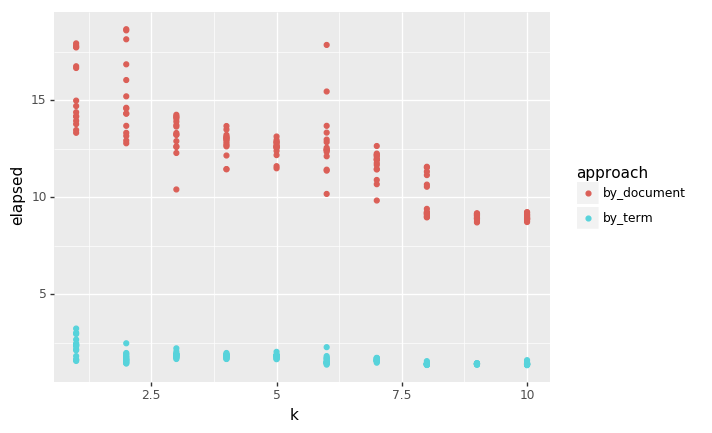

<ggplot: (-9223363292359846375)>

In [260]:
(ggplot(exp_results)  
 + geom_point(aes('k', 'elapsed', color="approach"))
)

## Conjunctive Retrieval Algorithm

In [292]:
index = index_df 
query = ['juíza','Luz','Ivani']
k = 5
def conjunctive_retrieval_by_term(index, query, k):
    try:
        import Queue as Q  # ver. < 3.0
    except ImportError:
        import queue as Q

    A = {}
    result = []
    R = Q.PriorityQueue()
    q = Q.PriorityQueue()
    L = index.loc[lambda df: df.word.isin(query)]

    for idx, row in enumerate(L.itertuples()):

        if idx == 0:
            for doc_id, freq in getattr(row, "_2"):
                A[doc_id] = freq        
        else:
            for doc_id, freq in getattr(row, "_2"):
                if doc_id not in A:
                    pass
                else:
                    A[doc_id] += freq        

    for doc_id, score in A.items():
        q.put(((-1) * score,doc_id))    

    i = 0
    while not q.empty() and i < k:
        pair = q.get()
        pair = ((-1) *pair[0],pair[1])
        result.append(pair)
        i += 1

    return result

## Placing some queries 

In [342]:
conj_queries = ["['nesta','55º']","['1964','ditadura']","['Humanos','Direitos']",
                "['Vladimir','Herzog']","['Vladimir','Putin']"]

conj_df = pd.DataFrame(conj_queries, columns=["query"])
conj_df["query"] = conj_df["query"].apply(lambda x: list(literal_eval(x)))
conj_df["conj_by_term"] = conj_df["query"].apply(lambda w: conjunctive_retrieval_by_term(index_df, w, k))

display(Markdown("***"))
display(Markdown("#### Result of *conjunctive retrieve by term* algorithm"))
display(HTML(conj_df.to_html(index=False)))
display(Markdown("***"))

***

#### Result of *conjunctive retrieve by term* algorithm

query,conj_by_term
"[nesta, 55º]","[(3, 0), (3, 26), (3, 85), (3, 90), (3, 111)]"
"[1964, ditadura]","[(14, 24), (11, 165), (11, 215), (10, 164), (10, 171)]"
"[Humanos, Direitos]","[(2, 0), (2, 17), (2, 100), (2, 116), (2, 152)]"
"[Vladimir, Herzog]","[(4, 0), (2, 5), (2, 237), (1, 64), (1, 85)]"
"[Vladimir, Putin]","[(3, 165), (2, 0), (2, 85), (1, 5), (1, 64)]"


***

## Is the implementation correct?

In order to gather some evidence regarding whether the implementation is correct let's revisit the query *juíza,Luz,Ivani*

In [298]:
index_df.loc[index_df['word'].isin(['juíza','Luz','Ivani'])]

,word,doc_id:freq
0,juíza,"[(0, 2), (1, 1)]"
2,Ivani,"[(0, 1), (1, 1)]"
4,Luz,"[(0, 3), (1, 1), (124, 1)]"


As we're now using a **conjunctive** implementation only the documents that contain all the query words will be included in the result.

Consequently, the document of id=124 will be excluded as it doesn't contain neither "juíza" nor "Ivani". Finally the expected result of the *conjunctive retrieval by term* would be:

for k >= 2:

* [(6,0),(3,1)]

for k = 1:

* [(6,0)]


In [299]:
display(Markdown("##### The actual results:"))
print("k > 2 : {}".format(conjunctive_retrieval_by_term(index_df, ['juíza','Luz','Ivani'], 10)))
print("k = 2 : {}".format(conjunctive_retrieval_by_term(index_df, ['juíza','Luz','Ivani'], 2)))
print("k = 1 : {}".format(conjunctive_retrieval_by_term(index_df, ['juíza','Luz','Ivani'], 1)))

##### The actual results:

k > 2 : [(6, 0), (3, 1)]
k = 2 : [(6, 0), (3, 1)]
k = 1 : [(6, 0)]


> The results match and thus we have some evidence that the implementation is correct.